# Подготовка:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
print(os.listdir("./input"))


['unigram_freq.csv']


In [5]:
# Загружаем data frame
df  = pd.read_csv('./input/unigram_freq.csv')
print(df.shape)

# Избавляемся от пустых значений
df.dropna(axis=0,how='any')
print(df.shape)

df[:10]


(333333, 2)
(333333, 2)


,word,count
0,the,23135851162
1,of,13151942776
2,and,12997637966
3,to,12136980858
4,a,9081174698
5,in,8469404971
6,for,5933321709
7,is,4705743816
8,on,3750423199
9,that,3400031103


In [6]:
# Удаляем то, что не строчка
lines = [x for x in df['word'] if type(x) == type('a') ]
print("Line Count:",len(lines))
print(lines[:4])

Line Count: 333331
['the', 'of', 'and', 'to']


In [7]:
# Убираем лишние символы из слов
import re
def process(sent):
    sent=sent.lower()
    sent=re.sub(r'[^0-9a-zA-Z ]','',sent)
    sent=sent.replace('\n','')
    return sent

In [8]:
# Разбиваем 1 сэмл на отдельные слова и записываем в общую кучу
lines =[process(x) for x in lines]
temp = []
for line in lines:
    temp+= [ x for x in line.split() ]
lines = list(set(temp))
print("\n".join(lines[2:6]))
print("Number of items:",len(lines))

grimalkin
katzman
onp
borgers
Number of items: 333331


In [9]:
# Создадим словари того, чем будем "путать" слова
char_set = list(" abcdefghijklmnopqrstuvwxyz0123456789")
char2int = { char_set[x]:x for x in range(len(char_set)) }
int2char = { char2int[x]:x for x in char_set }

count = len(char_set)
codes = ["\t","\n",'#']
for i in range(len(codes)):
    code = codes[i]
    char2int[code]=count
    int2char[count]=code
    count+=1
print(char2int)
print(int2char)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33, '7': 34, '8': 35, '9': 36, '\t': 37, '\n': 38, '#': 39}
{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: '0', 28: '1', 29: '2', 30: '3', 31: '4', 32: '5', 33: '6', 34: '7', 35: '8', 36: '9', 37: '\t', 38: '\n', 39: '#'}


In [10]:
import random

def gen_gibberish(line,thresh=0.2):
    times = int(random.randrange(1,len(line)) * thresh)
    '''
    Types of replacement:
        1.Delete random character.
        2.Add random character.
        3.Replace a character.
        4.Combination?
    '''
    while times!=0:
        # try to gen noise length times...
        times-=1
        val = random.randrange(0,10)
        if val <= 5:
            #get random index
            val = random.randrange(0,10)
            index = random.randrange(2,len(line))
            if val <= 3 :
                #delete character
                line = line[:index]+line[index+1:]
            else:
                #add character
                insert_index = random.randrange(0,len(char_set))
                line = line[:index] + char_set[insert_index] + line[index:]
        else:
            index = random.randrange(0,len(char_set))
            replace_index = random.randrange(2,len(line))
            line = line[:replace_index] + char_set[index] + line[replace_index+1:]
    return line

sample = lines[random.randint(0, len(lines))]
gib = gen_gibberish(sample)
print("Original:",sample)
print("Gibberish:",gib)



Original: bric
Gibberish: bric


# Собираем датасет и прописываем параметры модели:

In [11]:
input_texts = []
target_texts = []
REPEAT_FACTOR = 1
SKIP = int(len(lines)*0.65)

for line in lines[SKIP:]:
    if len(line)>10:
        output_text = '\t' + line + '\n'
        for _ in range(REPEAT_FACTOR):
            input_text = gen_gibberish(line)
            input_texts.append(input_text)
            target_texts.append(output_text)
print("Количество сэмплов:",len(input_texts))

Количество сэмплов: 15183


In [12]:
max_enc_len = max([len(x) for x in input_texts])
max_dec_len = max([len(x) for x in target_texts])
print("Максимальная длина encoder:",max_enc_len)
print("Максимальная длина decoder:",max_dec_len)

Максимальная длина encoder: 34
Максимальная длина decoder: 36


In [13]:
num_samples = len(input_texts)
encoder_input_data = np.zeros( (num_samples , max_enc_len , len(char_set)),dtype='float32' )
decoder_input_data = np.zeros( (num_samples , max_dec_len , len(char_set)+2),dtype='float32' )
decoder_target_data = np.zeros( (num_samples , max_dec_len , len(char_set)+2),dtype='float32' )
print("Нулевые векторы данных созданы!")

Нулевые векторы данных созданы!


In [14]:
# Заполняем enc, dec, targ
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data[ i , t-1 , char2int[char] ] = 1
print("Векторы больше не нулевые!")

Векторы больше не нулевые!


In [36]:
from keras.models import Model, load_model
from keras.layers import Input,LSTM,Dense

In [23]:
batch_size = 128
epochs = 700
latent_dim = 256

num_enc_tokens = len(char_set)
num_dec_tokens = len(char_set) + 2 # includes \n \t
encoder_inputs = Input(shape=(None,num_enc_tokens))
encoder = LSTM(latent_dim,return_state=True)
encoder_outputs , state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h,state_c]


In [24]:
decoder_inputs = Input(shape=(None,num_dec_tokens))
decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_ouputs,_,_ = decoder_lstm(decoder_inputs,initial_state = encoder_states)

decoder_dense = Dense(num_dec_tokens, activation='softmax')
decoder_ouputs = decoder_dense(decoder_ouputs)

model = Model([encoder_inputs,decoder_inputs],decoder_ouputs)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, None, 37)]           0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, None, 39)]           0         []                            
                                                                                                  
 lstm_6 (LSTM)               [(None, 256),                301056    ['input_7[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

# Обучение
### Ранее была создана LSTM модель, загрузим в нее данные и поставим учиться:


In [25]:
h=model.fit(
    [encoder_input_data,decoder_input_data],
    decoder_target_data,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = 0.2
)


Epoch 1/700
95/95 [==============================] - 14s 139ms/step - loss: 1.1566 - val_loss: 1.1204
Epoch 2/700
95/95 [==============================] - 13s 133ms/step - loss: 1.1087 - val_loss: 1.1198
Epoch 3/700
95/95 [==============================] - 13s 136ms/step - loss: 1.0991 - val_loss: 1.0951
Epoch 4/700
95/95 [==============================] - 13s 135ms/step - loss: 1.0921 - val_loss: 1.0832
Epoch 5/700
95/95 [==============================] - 12s 128ms/step - loss: 1.0853 - val_loss: 1.0756
Epoch 6/700
95/95 [==============================] - 13s 137ms/step - loss: 1.0772 - val_loss: 1.0743
Epoch 7/700
95/95 [==============================] - 14s 142ms/step - loss: 1.0693 - val_loss: 1.0712
Epoch 8/700
95/95 [==============================] - 13s 138ms/step - loss: 1.0620 - val_loss: 1.0850
Epoch 9/700
95/95 [==============================] - 12s 125ms/step - loss: 1.0551 - val_loss: 1.0467
Epoch 10/700
95/95 [==============================] - 13s 132ms/step - loss: 1.048

/home/lcz/anaconda3/envs/nlp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
# Потом понадобиться
model.save('s2s.h5')

/home/lcz/anaconda3/envs/nlp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


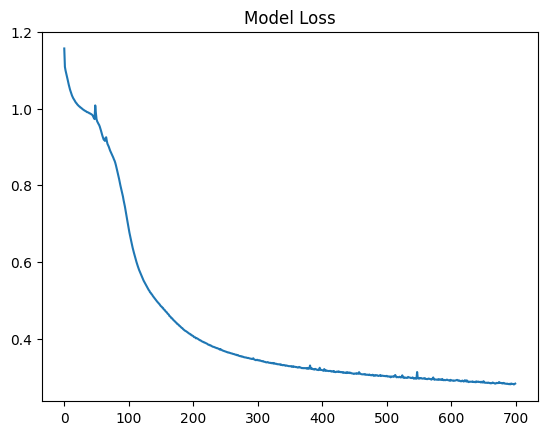

In [38]:
# Посмотрим на то, как менялась ошибка
plt.plot(h.history['loss'])
plt.title('Model Loss')
plt.show()

# Проверим модель на деле:

In [56]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c = decoder_lstm(
        decoder_inputs,initial_state = decoder_states_inputs
)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
# encoder_model.save('encoder.h5')
# decoder_model.save('decoder.h5')

encoder_model.compile()
decoder_model.compile()

max_dec_len = 11

def decode_sequence(input_seq):
    # Получаем состояния encoder'а
    states_value = encoder_model.predict(input_seq)

    # Создаем пустую целевую последовательность длиной 1 с начальным символом '\t'
    target_seq = np.zeros((1, 1, num_dec_tokens))
    target_seq[0, 0, char2int['\t']] = 1.

    # Флаг для завершения декодирования
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition and len(decoded_sentence) < max_dec_len:
        # Получаем предсказания от decoder'а
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Получаем индекс токена с наибольшей вероятностью
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Получаем символ, соответствующий индексу
        sampled_char = int2char[sampled_token_index]
        # Добавляем символ к выходной последовательности
        decoded_sentence += sampled_char

        # Если достигнут символ '\n' или максимальная длина, завершаем декодирование
        if sampled_char == '\n' or len(decoded_sentence) > max_dec_len:
            stop_condition = True

        # Обновляем целевую последовательность для следующего шага декодирования
        target_seq = np.zeros((1, 1, num_dec_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Обновляем состояния
        states_value = [h, c]

    return decoded_sentence[:max_dec_len]


for i in range(1):
    input_seq = encoder_input_data[i:i+1]
    decoded_sentence = decode_sequence(input_seq)
    
    # Фактическое значение
    target_text = target_texts[i]
    input_text = input_texts[i]
    
    # Выводим результаты
    print('-')
    print('Input sentence:', input_text)
    print('Decoded sentence:', decoded_sentence)
    print('Target sentence:', target_text)

1/1 [==============================] - 0s 9ms/step
-
Input sentence: nightejgale
Decoded sentence: nightengale
Target sentence: 	nightengale

